In [40]:
# PyTorch checking as I'm running a 5070ti and needs sm_120 support
# I had to install a dual boot Ubuntu to utilize my GPU
import torch
print("Torch version:", torch.__version__)
print("CUDA runtime:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
print("Arch list:", torch.cuda.get_arch_list())

Torch version: 2.10.0.dev20251206+cu128
CUDA runtime: 12.8
CUDA available: True
Arch list: ['sm_70', 'sm_75', 'sm_80', 'sm_86', 'sm_90', 'sm_100', 'sm_120']


In [41]:
import os
import random
from dataclasses import dataclass
from typing import Tuple

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [42]:
# Ensures reproducible results across runs for project criteria
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # CUDA params to ensure deterministic algorithms
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [43]:
@dataclass
class TrainConfig:
    # Data settings
    data_dir: str = "./archive/data/natural_images"
    val_split: float = 0.15  
    test_split: float = 0.15  
    img_size: int = 128

    # Training hyperparams
    batch_size: int = 64
    num_epochs: int = 25
    lr: float = 1e-3
    weight_decay: float = 1e-4

    # Model architecture
    num_classes: int = 8

    # System settings
    num_workers: int = 4
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 42

    # Logging and checkpoints
    log_interval: int = 50
    min_val_acc: float = 0.80
    checkpoint_path: str = "best_natural_images_cnn.pth"

In [44]:
class NaturalImagesCnn(nn.Module):
    def __init__(self, num_classes: int = 8):
        super().__init__()

        # Feature extraction w/4 convolutional blocks w/progressive channel expansion
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Global pooling
            nn.AdaptiveAvgPool2d((1, 1)),
        )

        # Classification head w/dropout regularization
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [45]:
def get_dataloaders(cfg: TrainConfig):
    from torch.utils.data import Subset

    # ImageNet Normalization
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
    
    # Training transforms
    train_tfms = transforms.Compose([
        transforms.Resize((cfg.img_size, cfg.img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        normalize,
    ])

    # Validation/Test transforms (no augmentation)
    eval_tfms = transforms.Compose([
        transforms.Resize((cfg.img_size, cfg.img_size)),
        transforms.ToTensor(),
        normalize,
    ])

    # Create three dataset instances
    full_dataset_train = datasets.ImageFolder(root=cfg.data_dir, transform=train_tfms)
    full_dataset_val = datasets.ImageFolder(root=cfg.data_dir, transform=eval_tfms)
    full_dataset_test = datasets.ImageFolder(root=cfg.data_dir, transform=eval_tfms)

    # Calculate split sizes
    total_len = len(full_dataset_train)
    test_len = int(total_len * cfg.test_split)
    val_len = int(total_len * cfg.val_split)
    train_len = total_len - test_len - val_len

    # Seed before split for reproducibility
    set_seed(cfg.seed)
    
    # Split into train, val, test
    train_ds_temp, val_ds_temp, test_ds_temp = random_split(
        full_dataset_train, 
        [train_len, val_len, test_len]
    )
    
    # Apply same indices to respective dataset objects
    train_ds = Subset(full_dataset_train, train_ds_temp.indices)
    val_ds = Subset(full_dataset_val, val_ds_temp.indices)
    test_ds = Subset(full_dataset_test, test_ds_temp.indices)

    # Enable pinned memory for faster CPU to GPU transfer
    pin_mem = torch.cuda.is_available()

    train_loader = DataLoader(
        train_ds,
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=cfg.num_workers,
        pin_memory=pin_mem,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=pin_mem,
    )

    test_loader = DataLoader(
        test_ds,
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=pin_mem,
    )

    return train_loader, val_loader, test_loader


In [46]:
def train_one_epoch(model, loader, optimizer, device, epoch, log_interval=50):
    # Enable dropout and BatchNorm training mode
    model.train()
    criterion = nn.CrossEntropyLoss()
    running_loss = 0.0

    for batch_idx, (images, targets) in enumerate(loader):
        images, targets = images.to(device), targets.to(device)

        # Training step (zero gradients, forward pass, backprop, update)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # Function to print progress every log_interval batch
        if (batch_idx + 1) % log_interval == 0:
            avg_loss = running_loss / log_interval
            print(f"Epoch {epoch} Step {batch_idx+1}: Loss = {avg_loss:.4f}")
            running_loss = 0.0

In [47]:
# Disabling gradient computation for inference
@torch.no_grad()
def evaluate(model, loader, device):
    # Disable dropout for inference, use BatchNorm running statistics
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    correct = 0
    total = 0

    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)

        loss = criterion(outputs, targets)
        total_loss += loss.item() * images.size(0)

        # Get predicted class (idx of max logit)
        preds = outputs.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += images.size(0)

    return total_loss / total, correct / total


In [48]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

cfg = TrainConfig()
set_seed(cfg.seed)

model = NaturalImagesCnn(num_classes=cfg.num_classes).to(cfg.device)
train_loader, val_loader, test_loader = get_dataloaders(cfg)  # Note the third return value

optimizer = torch.optim.AdamW(model.parameters(),
                              lr=cfg.lr,
                              weight_decay=cfg.weight_decay)

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

best_acc = 0.0

for epoch in range(1, cfg.num_epochs + 1):
    train_one_epoch(model, train_loader, optimizer, cfg.device, epoch, cfg.log_interval)
    val_loss, val_acc = evaluate(model, val_loader, cfg.device)

    print(f"Epoch {epoch}: Validation Loss = {val_loss:.4f}, Accuracy = {val_acc:.4f}")
    
    scheduler.step(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "cfg": cfg.__dict__,
                "val_acc": val_acc,
            },
            "best_natural_images_cnn.pth",
        )
        print(f"New best model saved! Acc = {val_acc:.4f}")

Epoch 1 Step 50: Loss = 1.4345
Epoch 1: Validation Loss = 0.8235, Accuracy = 0.6896
New best model saved! Acc = 0.6896
Epoch 2 Step 50: Loss = 0.8549
Epoch 2: Validation Loss = 0.5789, Accuracy = 0.7911
New best model saved! Acc = 0.7911
Epoch 3 Step 50: Loss = 0.6515
Epoch 3: Validation Loss = 0.5601, Accuracy = 0.7863
Epoch 4 Step 50: Loss = 0.5879
Epoch 4: Validation Loss = 0.6027, Accuracy = 0.8114
New best model saved! Acc = 0.8114
Epoch 5 Step 50: Loss = 0.5261
Epoch 5: Validation Loss = 0.4986, Accuracy = 0.8153
New best model saved! Acc = 0.8153
Epoch 6 Step 50: Loss = 0.4868
Epoch 6: Validation Loss = 0.5188, Accuracy = 0.7969
Epoch 7 Step 50: Loss = 0.4922
Epoch 7: Validation Loss = 0.3416, Accuracy = 0.8627
New best model saved! Acc = 0.8627
Epoch 8 Step 50: Loss = 0.4286
Epoch 8: Validation Loss = 0.6480, Accuracy = 0.7718
Epoch 9 Step 50: Loss = 0.3980
Epoch 9: Validation Loss = 0.3086, Accuracy = 0.8665
New best model saved! Acc = 0.8665
Epoch 10 Step 50: Loss = 0.4047
Ep

In [50]:
# Load best checkpoint
checkpoint = torch.load(cfg.checkpoint_path, map_location=cfg.device)
model.load_state_dict(checkpoint["model_state_dict"])
print(f"Loaded model with validation accuracy: {checkpoint['val_acc']:.4f}")

Loaded model with validation accuracy: 0.9333


In [51]:
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import os

In [52]:
model.eval()

# Get class names from your dataset
# Assuming your dataset structure is: data_dir/class_name/images
class_names = sorted(os.listdir(cfg.data_dir))
print(f"Classes: {class_names}")

Classes: ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']


In [56]:
def predict_image(image_path, model, transform, device, class_names):
    """
    Predict the class of a single image
    """
    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        predicted_class = output.argmax(dim=1).item()
        confidence = probabilities[0][predicted_class].item()
    
    return predicted_class, confidence, probabilities[0].cpu().numpy()


DETAILED PREDICTION EXAMPLE


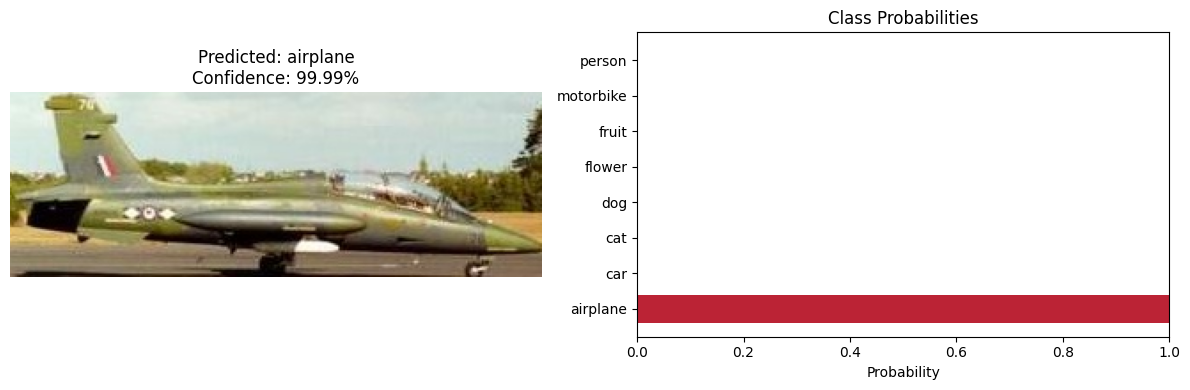


BATCH PREDICTIONS ON VALIDATION SET


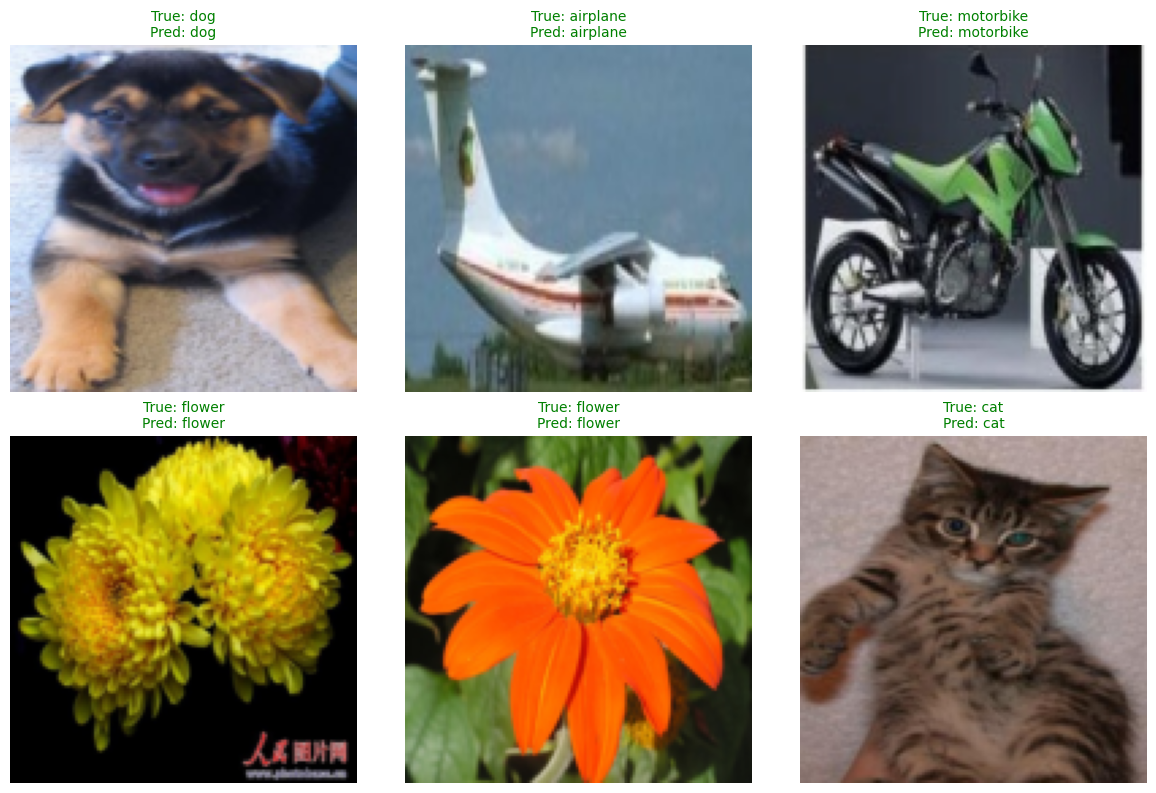


Batch Accuracy: 89.06% (57/64 correct)


In [ ]:
def visualize_predictions(image_paths, model, transform, device, class_names, num_images=3):
    """
    Visualize predictions for multiple images
    """
    fig, axes = plt.subplots(1, num_images, figsize=(7.2 * num_images / 3, 2.4))
    
    if num_images == 1:
        axes = [axes]
    
    for idx, image_path in enumerate(image_paths[:num_images]):
        # Load original image for display
        image = Image.open(image_path).convert('RGB')
        
        # Get prediction
        pred_class, confidence, probs = predict_image(image_path, model, transform, device, class_names)
        
        # Display image
        axes[idx].imshow(image)
        axes[idx].axis('off')
        axes[idx].set_title(f'Pred: {class_names[pred_class]}\nConf: {confidence:.2%}', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Create transform for prediction (same as validation transform)
predict_transform = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def show_detailed_prediction(image_path, model, transform, device, class_names):
    """
    Show detailed prediction with bar chart of probabilities
    """
    pred_class, confidence, probs = predict_image(image_path, model, transform, device, class_names)
    
    # Create figure with image and probability bar chart
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Display image
    image = Image.open(image_path).convert('RGB')
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title(f'Predicted: {class_names[pred_class]}\nConfidence: {confidence:.2%}')
    
    # Display probability bar chart
    y_pos = np.arange(len(class_names))
    ax2.barh(y_pos, probs)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(class_names)
    ax2.set_xlabel('Probability')
    ax2.set_title('Class Probabilities')
    ax2.set_xlim([0, 1])
    
    # Highlight predicted class
    ax2.barh(pred_class, probs[pred_class], color='red', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Show detailed prediction for first test image
print("\n" + "="*50)
print("DETAILED PREDICTION EXAMPLE")
print("="*50)
show_detailed_prediction(test_image_paths[0], model, predict_transform, cfg.device, class_names)

# Batch prediction on validation set
print("\n" + "="*50)
print("BATCH PREDICTIONS ON VALIDATION SET")
print("="*50)

# Get a batch from validation loader
val_images, val_labels = next(iter(val_loader))
val_images = val_images.to(cfg.device)
val_labels = val_labels.to(cfg.device)

# Make predictions
with torch.no_grad():
    outputs = model(val_images)
    _, predicted = torch.max(outputs, 1)

# Visualize first 6 images from the batch
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

for idx in range(min(6, len(val_images))):
    # Denormalize image for display
    img = val_images[idx].cpu()
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img = torch.clamp(img, 0, 1)
    
    # Convert to numpy and transpose for matplotlib
    img = img.numpy().transpose(1, 2, 0)
    
    # Display
    axes[idx].imshow(img)
    axes[idx].axis('off')
    
    true_label = class_names[val_labels[idx].item()]
    pred_label = class_names[predicted[idx].item()]
    color = 'green' if val_labels[idx] == predicted[idx] else 'red'
    
    axes[idx].set_title(f'True: {true_label}\nPred: {pred_label}', 
                        color=color, fontsize=10)

plt.tight_layout()
plt.show()

# Calculate accuracy on this batch
correct = (predicted == val_labels).sum().item()
batch_accuracy = correct / len(val_labels)
print(f"\nBatch Accuracy: {batch_accuracy:.2%} ({correct}/{len(val_labels)} correct)")


PREDICTIONS ON TEST SET IMAGES


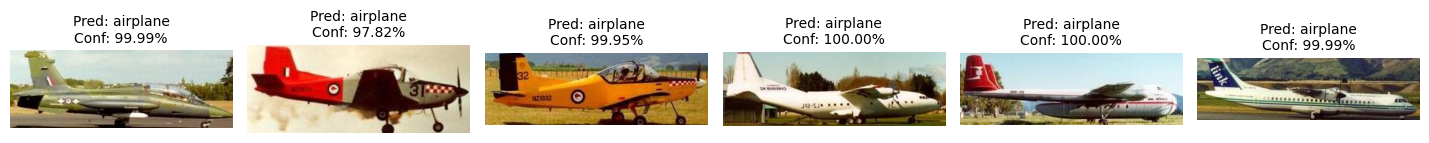

In [60]:
print("\n" + "="*50)
print("PREDICTIONS ON TEST SET IMAGES")
print("="*50)

# Get some test images 
test_dataset = datasets.ImageFolder(root=cfg.data_dir, transform=predict_transform)
test_indices = list(range(len(test_dataset)))[:6]  # Get first 6 images

test_image_paths = []
for idx in test_indices:
    img_path, label = test_dataset.samples[idx]
    test_image_paths.append(img_path)

visualize_predictions(test_image_paths, model, predict_transform, cfg.device, class_names, num_images=6)